# Road marking detection.
Project done by:
* Stepan Kuznetsov
* Egor Gorozhanking
* Evgeniy Panov

## Code, to be used in the future.

### Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time
import cv2
import math

In [2]:
# Code for easier plotting images in .ipynb IDE. Taken from Labs of this course.
def showInRow(list_of_images, titles = None, disable_ticks = False):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])
      
        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

### Video to images convertation.

In [3]:
# Code for converting videos into photos.
video = cv2.VideoCapture('dataset/Videos/input.mp4')
isTaken, image = video.read() 
count = 0
while isTaken:
    # Converting only each 5th image for speeding up our processing later.
    if count % 5 != 0:
        isTaken, image = video.read()
        count += 1
        continue
        
    # Saving image into "dataset/Images" folder.
    cv2.imwrite(f"dataset/Images/{count//5}.jpg", image) 
    isTaken, image = video.read()
    count += 1

#### Example of converted parts.

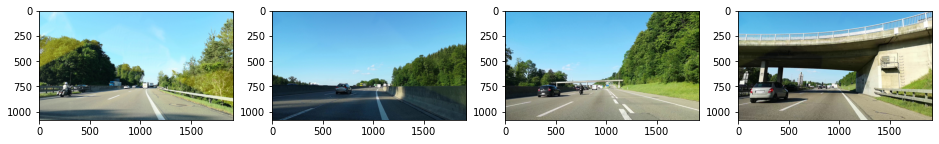

In [4]:
images = []
for i in range(0, 293, 80):
    imgbgr = cv2.imread(f"dataset/Images/{i}.jpg", cv2.IMREAD_COLOR)
    img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    images.append(img_result)
    
showInRow(images)

### Main code

In [5]:
def canny_edge_detection(image):
    # Preparing image for edge detection.
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0) # Blur should be already tuned enough.
    
    # Dynamically finding thresholds for cv2.Canny.
    # It could be tuned by hands, but the amoung of light in each separate
    # image is not constant, so dynamic way should work much better.
    high_thresh, thresh_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lowThresh = 0.5 * high_thresh
    
    # Doing the Canny itself.
    canny = cv2.Canny(blur, lowThresh, high_thresh)
    return canny


# Generating layer, which contains found lines only.
def line_layer_generation(image, lines):
    line_image = np.zeros_like(image)
    
    # If no lines found, just return empty lines layer.
    if lines is None:
        return line_image
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Checking if coords are in image range.
            x1 = min(max(x1, 0), image.shape[1])
            x2 = min(max(x2, 0), image.shape[1])
            
            y1 = min(max(y1, 0), image.shape[0])
            y2 = min(max(y2, 0), image.shape[0])
            
            # Removing horizontal edges (mostly noize erasing).
            angle = math.atan2(y2 - y1, x2 - x1)
            if abs(angle) > 2.85 or abs(angle) < 0.29:
                continue
            
            # Drawing line having coords.
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 20)
    return line_image

# Cropping image to the part, where lines could be found.
# If working with the whole image, it looks impossible to
# sort out all the noize and trash we find.
def cropping_image(image):
    # Getting size of image.
    height = image.shape[0]
    width = image.shape[1]
    
    # Defining area, in which lines could be found.
    # Active parameter, which is calibrated for each car separately.
    # In our case calibration was done by hand, but can be automated.
    # If must be array of >=3 points, to define area.
    points = np.array([(0, height), (810, 820), (1070, 820), (1270, height)])
    
    # Generating cropped image.
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, np.array([points], dtype=np.int64), 1024)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# Main function, doing the processing of an image.
def line_detection(image):
    img = np.copy(image)
    
    # Canny Edge Detection.
    canny_image = canny_edge_detection(img)
    
    # Cropping area of interest.
    cropped_image = cropping_image(canny_image)
    
    # Finding lines (long enough and with holes small enough) from our edges.
    # Tunable values here (depends on country and road condition): 
    # minLineLength - min length of interesting lines;
    # maxLineGap - max gap between two edges, giving one line.
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 20, np.array([()]), minLineLength=80, maxLineGap=60)
    
    # Drawing lines on our image.
    line_layer = line_layer_generation(img, lines)
    resulting_image = cv2.addWeighted(img, 0.8, line_layer, 1, 1)
    return resulting_image

## Results of work

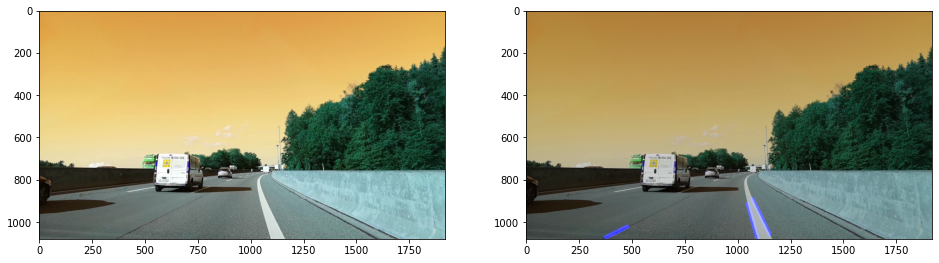

In [9]:
# One image example.
image = cv2.imread("dataset/Images/100.jpg", cv2.IMREAD_COLOR)
result = line_detection(image)
showInRow([image, result])

### Convertin whole database into one video

In [7]:
# Doing the same for all the images in "dataset/Images" folder.
computed_imgs = []

for i in range(293):
    image = cv2.imread(f"dataset/Images/{i}.jpg", cv2.IMREAD_COLOR)
    computed_imgs.append(line_detection(image))

In [8]:
# Making video out of our images.
size = (computed_imgs[0].shape[1], computed_imgs[0].shape[0])
out = cv2.VideoWriter('dataset/Videos/output.mp4',cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 5, size)
for i in range(len(computed_imgs)):
    for _ in range(1):
        out.write(computed_imgs[i])
out.release()